In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data as Data

from torchsummary import summary

In [2]:
import yfinance as yf

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data = pd.read_csv("GOOG.csv")
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-06-03,539.91,543.50,537.11,540.31,1717000,0,0
1,2015-06-04,537.76,540.59,534.32,536.70,1348300,0,0
2,2015-06-05,536.35,537.20,532.52,533.33,1388200,0,0
3,2015-06-08,533.31,534.12,526.24,526.83,1520600,0,0
4,2015-06-09,527.56,529.20,523.01,526.69,1455300,0,0
...,...,...,...,...,...,...,...,...
1254,2020-05-27,1417.25,1421.74,1391.29,1417.84,1685800,0,0
1255,2020-05-28,1396.86,1440.84,1396.00,1416.73,1692200,0,0
1256,2020-05-29,1416.94,1432.57,1413.35,1428.92,1838100,0,0
1257,2020-06-01,1418.39,1437.96,1418.00,1431.82,1217100,0,0


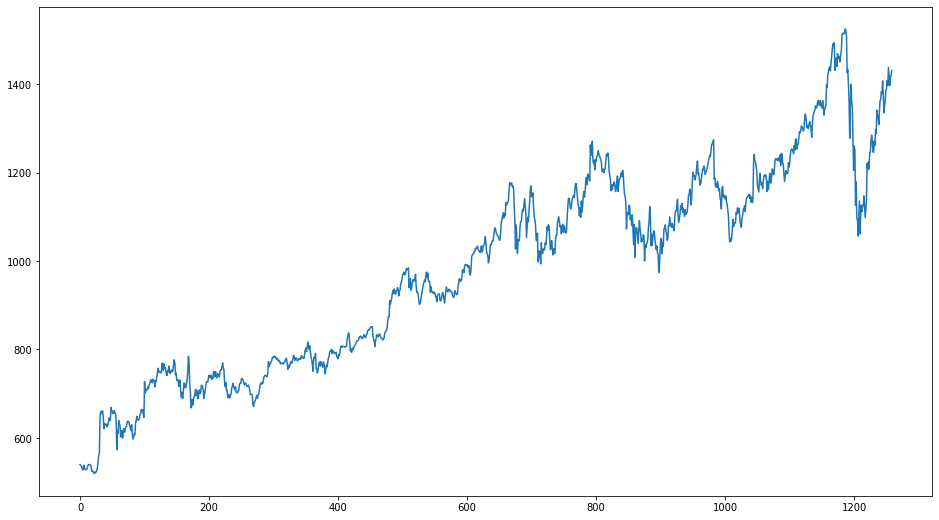

In [5]:
data['Open'].plot(figsize=(16, 9))

In [6]:
dataset_train = data
training_set = dataset_train.iloc[:, 1:2].values

In [7]:
len(training_set)

1259

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
X_train = []
y_train = []
for i in range(60, len(training_set)-200):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)

In [10]:
X_train.shape

torch.Size([999, 60])

In [11]:
y_train = y_train.reshape(1, len(X_train), -1)

In [12]:
y_train.shape

torch.Size([1, 999, 1])

In [13]:
X_train = X_train.reshape(1, len(X_train), 60)

In [14]:
X_train.shape

torch.Size([1, 999, 60])

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=4, dropout=0.1)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, inputs):
        output, hidden = self.lstm(inputs)
        out = self.linear(output)
        return(out)

In [16]:
model = LSTM(60, 70)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model.to(device)

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.1)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

In [18]:
X_train = X_train.to(device)
X_train.device

device(type='cuda', index=0)

In [19]:
y_train = y_train.to(device)
y_train.device

device(type='cuda', index=0)

In [20]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.zero_grad()
    y_pred = model(X_train)
    loss= loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch%10==0:
        print("Epoch: ", epoch+1, "| Loss: ", float(loss))

Epoch:  1 | Loss:  0.15619565546512604
Epoch:  11 | Loss:  0.11219118535518646
Epoch:  21 | Loss:  0.05816468596458435
Epoch:  31 | Loss:  0.022311458364129066
Epoch:  41 | Loss:  0.01774149015545845
Epoch:  51 | Loss:  0.014728335663676262
Epoch:  61 | Loss:  0.011129629798233509
Epoch:  71 | Loss:  0.007504912558943033
Epoch:  81 | Loss:  0.005403898656368256
Epoch:  91 | Loss:  0.0044236015528440475
Epoch:  101 | Loss:  0.0038148192688822746
Epoch:  111 | Loss:  0.003813692834228277
Epoch:  121 | Loss:  0.0032748684752732515
Epoch:  131 | Loss:  0.003470237599685788
Epoch:  141 | Loss:  0.0029389422852545977
Epoch:  151 | Loss:  0.002930505434051156
Epoch:  161 | Loss:  0.0027143817860633135
Epoch:  171 | Loss:  0.0024812750052660704
Epoch:  181 | Loss:  0.002466346835717559
Epoch:  191 | Loss:  0.002266399096697569
Epoch:  201 | Loss:  0.0022595305927097797
Epoch:  211 | Loss:  0.00209670327603817
Epoch:  221 | Loss:  0.0017759909387677908
Epoch:  231 | Loss:  0.0018355672946199775

In [21]:
model.to("cpu")

LSTM(
  (lstm): LSTM(60, 70, num_layers=4, dropout=0.1)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

## Test

In [22]:
# Getting the stock price of 2020
dataset_test = pd.read_csv("GOOG.csv")
dataset_test = dataset_test.iloc[-200:]
len(dataset_test)

200

In [23]:
real_stock_price = dataset_test.iloc[:, 1:2].values

In [24]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = torch.Tensor(X_test)
X_test = X_test.reshape(1, len(X_test), 60)
predicted_stock_price = model(X_test)
predicted_stock_price = torch.Tensor.cpu(predicted_stock_price).detach().numpy()[-1]
predicted_stock_price = sc.inverse_transform(np.array(predicted_stock_price))

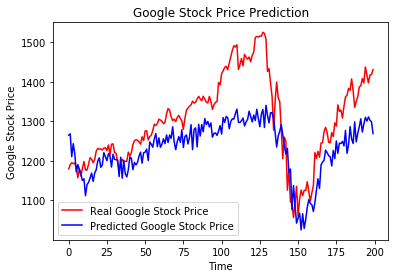

In [25]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()